In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry


import statsmodels.formula.api as smf
import statsmodels.api as sm

np.random.seed(123)


## Prepare the data

In [26]:
data = pd.read_csv("data/train_new.csv")
data = data.sample(frac = 0.1)

print(data.shape)
data.head()

(9917530, 21)


In [27]:
data.columns

Index(['Unnamed: 0', 'click_bool', 'booking_bool', 'random_bool',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'orig_destination_distance'],
      dtype='object')

In [28]:
data["not_random_bool"] = 1 - data['random_bool'] #study the causal effect of turing ON the ranking algo

train_data = data.sample(frac = 0.6)
test_data = data.drop(train_data.index)
print(train_data.shape, test_data.shape)

## Train the Models

### (1) Baseline: fully interacted linear regression

In [35]:
### Fully interacted model, remove booking_bool, position
m1_lr = smf.ols("click_bool ~ not_random_bool + not_random_bool*visitor_hist_starrating + not_random_bool*visitor_hist_adr_usd + not_random_bool*prop_starrating + not_random_bool*prop_review_score + not_random_bool*prop_brand_bool + not_random_bool*prop_location_score1 + not_random_bool*prop_log_historical_price + not_random_bool*price_usd + not_random_bool*promotion_flag + not_random_bool*srch_length_of_stay + not_random_bool*srch_booking_window + not_random_bool*srch_adults_count + not_random_bool*srch_children_count + not_random_bool*srch_room_count + not_random_bool*srch_saturday_night_bool + not_random_bool*orig_destination_distance", data = train_data).fit()

### (2) Meta Learners, DRLearner, DML, NonParamDML

### (3) DMLOrthoForest, DROrthoForest, ForestDRLeaner, CausalForestDML

## Evaluation

In [ ]:
#predict individual level treatment effect
def predict_cate(model, df):
    return (model.predict(df.assign(not_random_bool=1))
            - model.predict(df.assign(not_random_bool=0)))

In [38]:
test_data_pred["cate_pred"].describe()

count    3.967012e+06
mean    -3.477306e-03
std      3.658743e-03
min     -5.385358e-01
25%     -5.748428e-03
50%     -3.579558e-03
75%     -1.213987e-03
max      1.861026e-02
Name: cate_pred, dtype: float64

### (1) Treatment Effect by Model Band

In [61]:
@curry
def cate(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))


def cate_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(cate(y=y, t=t))) # estimate the elasticity on each partition


def draw_cate_by_band_plot(test_data, model):
        test_data_pred = test_data.assign(**{
                "cate_pred": predict_cate(model, test_data), 
        })

        fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 4))
        ax.set_ylabel("Group ATE (ground-truth)")
        cate_by_band(test_data_pred, "cate_pred", "click_bool", "not_random_bool").plot.bar(ax=ax)



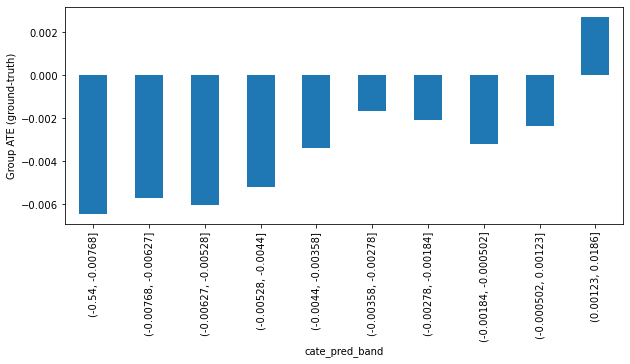

In [63]:
## Sample usage: plot the graph for a single model, evaluated on the test data
draw_cate_by_band_plot(test_data, m1_lr)

In [64]:
# TODO: evaluate multiple models in a single big plots




### (2) Cumulative TE Curve

In [52]:
def cumulative_te_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the elasticity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([cate(ordered_df.head(rows), y, t) for rows in n_rows])




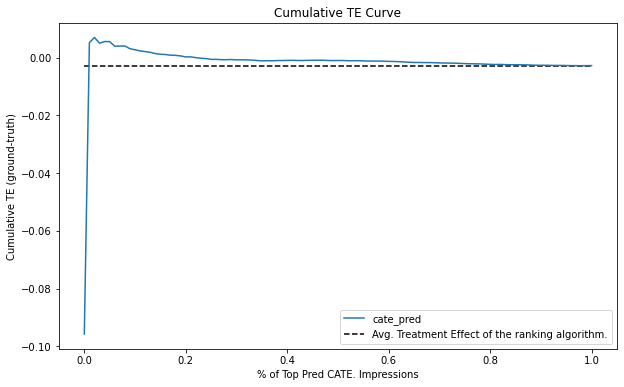

In [56]:
plt.figure(figsize=(10,6))

for m in ["cate_pred"]:
    cumu_elast = cumulative_te_curve(test_data_pred, m, "click_bool", "not_random_bool", min_periods=100, steps=100)
    x = np.array(range(len(cumu_elast)))
    plt.plot(x/x.max(), cumu_elast, label=m)

plt.hlines(cate(test_data_pred, "click_bool", "not_random_bool"), 0, 1, linestyles="--", color="black", label="Avg. Treatment Effect of the ranking algorithm.")
plt.xlabel("% of Top Pred CATE. Impressions")
plt.ylabel("Cumulative TE (ground-truth)")
plt.title("Cumulative TE Curve")
plt.legend();